Practica 1: Perceptrón Multicapa
Mally Samira Hernandez Martinez | Código: 220286113 
Ingenieria de computacion (INCO) | Seccion D05 I7041
Seminario de Solucion de Problemas de Inteligencia Artificial II

Importar librerías y Cargar los Datos

In [123]:
# Importar librerías
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import warnings
import time
import seaborn as sns

# Desactivar advertencias
warnings.filterwarnings('ignore')

# Fijar semilla para reproducibilidad
np.random.seed(10)

# Mostrar los archivos de la carpeta 'MNIST'
for dirname, _, filenames in os.walk('MNIST'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


MNIST\test.csv
MNIST\train.csv


Cargar y visualizar los datos

In [124]:
# Cargar los datos
df_train = pd.read_csv('MNIST/train.csv')
df_test = pd.read_csv('MNIST/test.csv')

# Mostrar el tamaño de los datasets
print("Tamaño del dataset de entrenamiento:", df_train.shape)
print("Tamaño del dataset de prueba:", df_test.shape)

# Mostrar las primeras filas del conjunto de entrenamiento
df_train.head()

Tamaño del dataset de entrenamiento: (42000, 785)
Tamaño del dataset de prueba: (28000, 784)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Preprocesamiento de los datos

In [125]:
# Separar las etiquetas de las imágenes
x = df_train.drop(columns='label')
y = df_train['label']

# Normalizar los datos dividiendo por 255 (Asegúrate de hacer esto también para x_test)
x = x / 255.0
x_test = df_test / 255.0  # Aquí también falta normalizar x_test

print("Tamaño de x_test:",x_test.shape) 

# Dividir el conjunto de entrenamiento en entrenamiento y validación
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=42)

# Mostrar el tamaño de los conjuntos
print("Tamaño de x_train:", x_train.shape)
print("Tamaño de x_val:", x_val.shape)
print("Tamaño de y_train:", y_train.shape)
print("Tamaño de y_val:", y_val.shape)

Tamaño de x_test: (28000, 784)
Tamaño de x_train: (29400, 784)
Tamaño de x_val: (12600, 784)
Tamaño de y_train: (29400,)
Tamaño de y_val: (12600,)


Visualización de un dígito

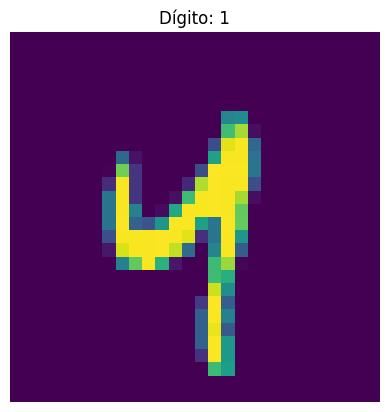

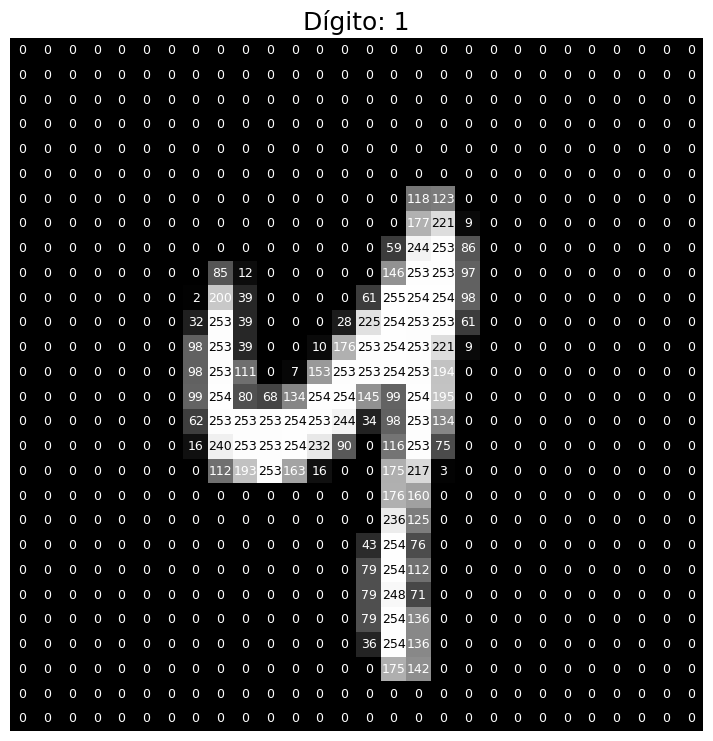

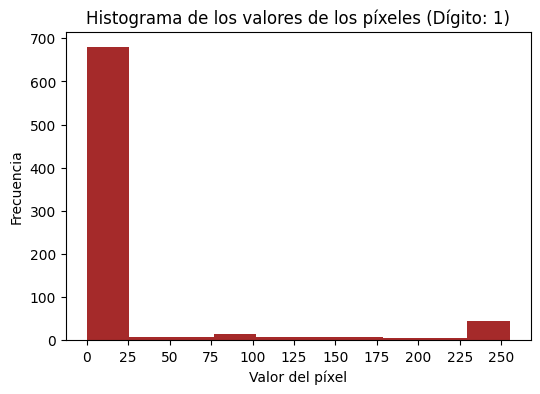

In [126]:
# Mostrar la imagen del primer dígito del conjunto de entrenamiento
plt.imshow(x_train.to_numpy()[0].reshape(28,28))
plt.title(f"Dígito: {y.iloc[0]}")  # Usamos la etiqueta original antes de la conversión a one-hot
plt.axis("off")
plt.show()

# Obtener el primer dígito de x_train y su correspondiente etiqueta
first_image = x_train.iloc[0].to_numpy().reshape(28, 28) * 255  # Se multiplica por 255 para volver a los valores originales
first_label = y.iloc[0]  # Obtener la etiqueta original directamente del DataFrame antes del one-hot

# Crear la figura con un tamaño mayor para mejor visualización
plt.figure(figsize=(9, 9))
plt.imshow(first_image, cmap='gray')  # Mostrar la imagen en escala de grises
plt.title(f"Dígito: {first_label}", fontsize=18)
plt.axis("off")

# Añadir los valores de los píxeles en cada celda
for i in range(28):
    for j in range(28):
        pixel_value = int(first_image[i, j])  # Convertir a entero
        # Si el píxel es muy claro (cercano a blanco), usar texto negro, sino usar texto blanco
        text_color = 'black' if pixel_value > 200 else 'white'
        plt.text(j, i, str(pixel_value), ha='center', va='center', color=text_color, 
                 fontsize=9, bbox=dict(facecolor='none', edgecolor='none'))

plt.show()

# Mostrar un histograma de los valores de los píxeles
plt.figure(figsize=(6, 4))
# Reducimos los bins para aumentar el grosor de las barras
plt.hist(first_image.flatten(), bins=10, color='brown', alpha=1.0) 
plt.title(f"Histograma de los valores de los píxeles (Dígito: {first_label})")
plt.xlabel('Valor del píxel')
plt.ylabel('Frecuencia')
plt.xticks(np.arange(0, 256, 25)) 
plt.show()


One-Hot Encoding de las etiquetas

In [127]:
# Convertir las etiquetas a formato categórico (one-hot encoding)
y_train = keras.utils.to_categorical(y_train, 10)
y_val = keras.utils.to_categorical(y_val, 10)

print("Forma de y_train (one-hot):", y_train.shape)

Forma de y_train (one-hot): (29400, 10)


Definición del Modelo

In [128]:
# Definir el modelo MLP
model = keras.Sequential()

# Agregar capas ocultas
model.add(keras.layers.Dense(128, activation='relu', input_shape=(784,)))
model.add(keras.layers.Dense(64, activation='relu'))

# Capa de salida con 10 neuronas y softmax
model.add(keras.layers.Dense(10, activation='softmax'))

# Compilar el modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Mostrar un resumen del modelo
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

Entrenamiento del modelo

In [129]:
# Entrenar el modelo
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))

# Imprimir las claves de las métricas guardadas
print(history.history.keys())

Epoch 1/10
919/919 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8310 - loss: 0.5725 - val_accuracy: 0.9510 - val_loss: 0.1685
Epoch 2/10
919/919 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9599 - loss: 0.1397 - val_accuracy: 0.9586 - val_loss: 0.1335
Epoch 3/10
919/919 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9716 - loss: 0.0961 - val_accuracy: 0.9667 - val_loss: 0.1115
Epoch 4/10
919/919 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9792 - loss: 0.0662 - val_accuracy: 0.9637 - val_loss: 0.1192
Epoch 5/10
919/919 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9838 - loss: 0.0513 - val_accuracy: 0.9700 - val_loss: 0.1009
Epoch 6/10
919/919 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9887 - loss: 0.0365 - val_accuracy: 0.9705 - val_loss: 0.1071
Epoch 7/10
919/919 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9900 - loss: 0.0309 - val_accuracy: 0.9678 - val_loss: 0.1178
Epoch 8/10
919/919 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9928 - loss: 0.0227 - val_accuracy: 0

Graficar la precisión y la pérdida

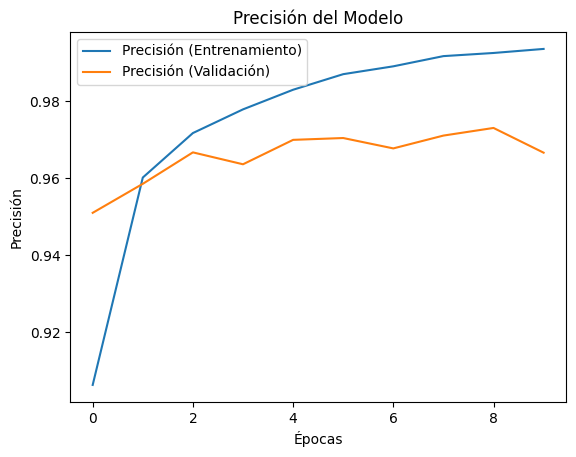

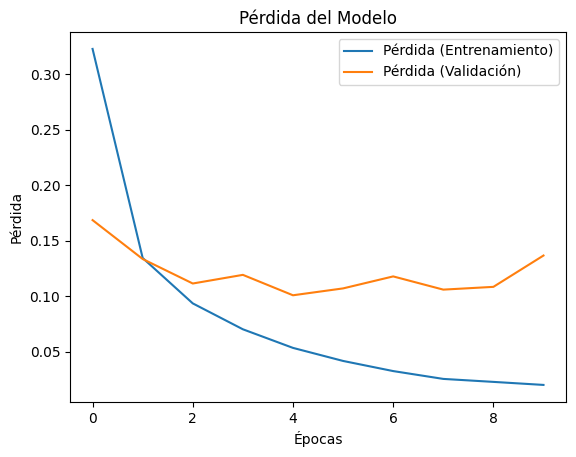

In [130]:
# Graficar la precisión
plt.plot(history.history['accuracy'], label='Precisión (Entrenamiento)')
plt.plot(history.history['val_accuracy'], label='Precisión (Validación)')
plt.title('Precisión del Modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Graficar la pérdida
plt.plot(history.history['loss'], label='Pérdida (Entrenamiento)')
plt.plot(history.history['val_loss'], label='Pérdida (Validación)')
plt.title('Pérdida del Modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

Evaluación del modelo en el conjunto de prueba

In [131]:
# Evaluar el modelo en el conjunto de prueba
y_pred = model.predict(x_test)
print(np.argmax(y_pred, axis=1)[:10])


875/875 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
[2 0 9 9 3 7 0 3 0 3]


Matriz de confusión

394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


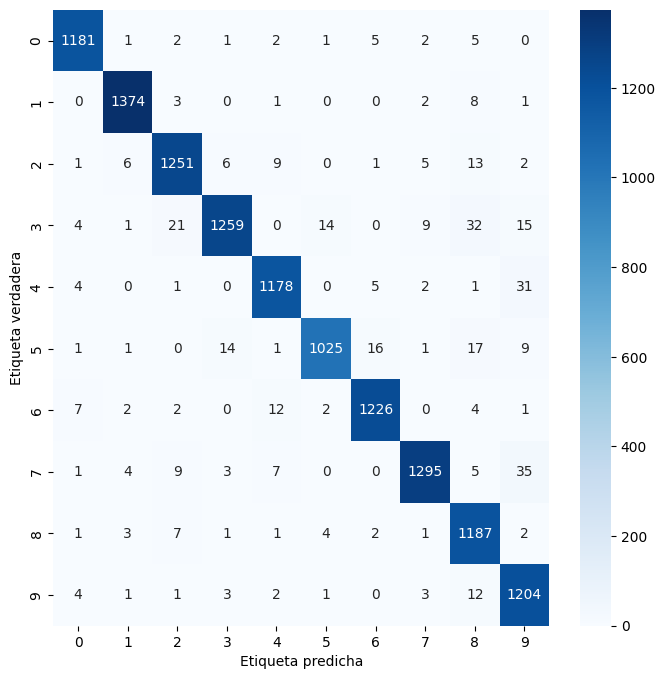

In [132]:
# Predecir en los datos de validación
y_pred = model.predict(x_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

# Matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Graficar la matriz de confusión
plt.figure(figsize=(8,8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.ylabel('Etiqueta verdadera')
plt.xlabel('Etiqueta predicha')
plt.show()